# Taller Práctico Clase 9: Reducción de Dimensionalidad

**Objetivo:** En este taller, aplicaremos y compararemos las tres técnicas de reducción de dimensionalidad vistas en clase: PCA (Análisis de Componentes Principales), t-SNE y UMAP. 

**Dataset:** Usaremos el dataset `digits` de Scikit-learn, que contiene imágenes de 8x8 píxeles de dígitos escritos a mano (0-9). Cada imagen está "aplanada" en un vector de 64 características (dimensiones), lo que lo convierte en un excelente candidato para la reducción de dimensionalidad y la visualización.

## 1. Configuración e Importación de Librerías

In [20]:
# Librerías para manipulación de datos
import numpy as np
import pandas as pd

# Librerías para visualización
import plotly.express as px
import matplotlib.pyplot as plt

# Scikit-learn para carga de datos, preprocesamiento y modelos
from sklearn.datasets import load_digits
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# UMAP (es necesario instalarlo: pip install umap-learn)
import umap

# Configuraciones adicionales
pd.options.plotting.backend = 'plotly'

## 2. Carga y Exploración del Dataset

In [21]:
# Cargamos el dataset de dígitos
digits = load_digits()

# X tiene los datos de las imágenes (las características)
X = digits.data

# y contiene las etiquetas verdaderas (el dígito del 0 al 9)
y = digits.target

print(f"Forma de la matriz de características (X): {X.shape}")
print(f"Forma del vector de etiquetas (y): {y.shape}")

Forma de la matriz de características (X): (1797, 64)
Forma del vector de etiquetas (y): (1797,)


Cada imagen tiene 64 píxeles (8x8), que actúan como nuestras características. Tenemos 1797 imágenes en total.

Para tener una idea de cómo se ven los datos, podemos visualizar algunas de las imágenes.

In [22]:
digits.images[0]

array([[ 0.,  0.,  5., 13.,  9.,  1.,  0.,  0.],
       [ 0.,  0., 13., 15., 10., 15.,  5.,  0.],
       [ 0.,  3., 15.,  2.,  0., 11.,  8.,  0.],
       [ 0.,  4., 12.,  0.,  0.,  8.,  8.,  0.],
       [ 0.,  5.,  8.,  0.,  0.,  9.,  8.,  0.],
       [ 0.,  4., 11.,  0.,  1., 12.,  7.,  0.],
       [ 0.,  2., 14.,  5., 10., 12.,  0.,  0.],
       [ 0.,  0.,  6., 13., 10.,  0.,  0.,  0.]])

In [23]:
digits.data

array([[ 0.,  0.,  5., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ..., 10.,  0.,  0.],
       [ 0.,  0.,  0., ..., 16.,  9.,  0.],
       ...,
       [ 0.,  0.,  1., ...,  6.,  0.,  0.],
       [ 0.,  0.,  2., ..., 12.,  0.,  0.],
       [ 0.,  0., 10., ..., 12.,  1.,  0.]])

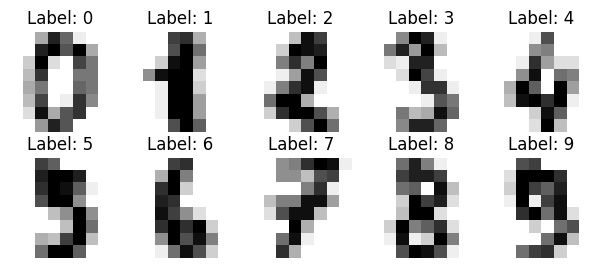

In [24]:
plt.figure(figsize=(7.5, 3))
for index, (image, label) in enumerate(zip(digits.images[:10], digits.target[:10])):
    plt.subplot(2, 5, index + 1)
    plt.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    plt.axis('off')
    plt.title('Label: %i' % label)
plt.show()

## 3. Preprocesamiento: Escalado de Datos

Como vimos en la teoría, PCA es sensible a la escala de las características. Aunque en este caso todos los píxeles están en una escala similar (0-16), es una buena práctica estandarizar los datos para que tengan media 0 y desviación estándar 1. Esto asegura que cada característica contribuya por igual al análisis.

In [25]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

## 4. Análisis de Componentes Principales (PCA)

Comenzaremos aplicando PCA para reducir la dimensionalidad de 64 a 2 componentes para poder visualizar los datos en un gráfico de dispersión.

### 4.1. Varianza Explicada

Antes de reducir a 2D, es útil ajustar PCA con todos los componentes posibles para ver cuánta varianza explica cada uno. El **Scree Plot** nos ayudará a decidir cuántos componentes son "suficientes".

In [26]:
# Ajustamos PCA sin especificar n_components para mantenerlos todos
pca_full = PCA()
pca_full.fit(X_scaled)

# Calculamos la varianza explicada acumulada
cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_)

# Creamos el Scree Plot
fig = px.area(x=range(1, cumulative_variance.shape[0] + 1),
              y=cumulative_variance,
              labels={"x": "Número de Componentes Principales", "y": "Varianza Explicada Acumulada"},
              title="Scree Plot: Varianza Explicada por los Componentes Principales")
fig.update_layout(yaxis_range=[0,1.05])
fig.add_hline(y=0.9, line_dash="dash", line_color="red")
fig.add_annotation(x=30, y=0.9, text="90% de Varianza Explicada", showarrow=True, arrowhead=1)
fig.show()

**Interpretación:** Podemos ver que con aproximadamente 10 componentes ya capturamos más del 60% de la varianza, y con unos 30 componentes, superamos el 90%. Esto nos dice que hay mucha redundancia en los 64 píxeles y que podemos representar los datos con mucha menos información sin una pérdida masiva.

Ahora, vamos a reducir a solo 2 componentes para la visualización.

### 4.2. Reducción a 2D y Visualización

In [27]:
# Aplicamos PCA para reducir a 2 dimensiones
pca_2d = PCA(n_components=2)
X_pca = pca_2d.fit_transform(X_scaled)

# Creamos un DataFrame para facilitar la visualización con Plotly
df_pca = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])
df_pca['label'] = y.astype(str) # Convertimos la etiqueta a string para colores discretos

# Visualizamos
fig = px.scatter(df_pca, x='PC1', y='PC2', color='label',
                 title='Visualización del Dataset Digits con PCA (2 Componentes)',
                 labels={'color': 'Dígito'})
fig.show()

**Análisis de PCA:** PCA logra una separación decente para algunos dígitos (como el 0, 4 y 6), pero muchos otros se superponen significativamente. Esto es esperado, ya que PCA está limitado a proyecciones lineales.

## 5. t-SNE (t-distributed Stochastic Neighbor Embedding)

Ahora, aplicaremos t-SNE, una técnica no lineal, para ver si podemos obtener una mejor separación visual de los clusters de dígitos.

In [28]:
# Aplicamos t-SNE. Perplexity es un hiperparámetro importante.
tsne = TSNE(n_components=2, perplexity=100, random_state=1)
X_tsne = tsne.fit_transform(X_scaled)

# Creamos el DataFrame para Plotly
df_tsne = pd.DataFrame(data=X_tsne, columns=['TSNE1', 'TSNE2'])
df_tsne['label'] = y.astype(str)

# Visualizamos
fig = px.scatter(df_tsne, x='TSNE1', y='TSNE2', color='label',
                 title='Visualización del Dataset Digits con t-SNE',
                 labels={'color': 'Dígito'})
fig.show()

**Análisis de t-SNE:** ¡El resultado es drásticamente mejor! t-SNE logra formar clusters muy definidos y separados para cada dígito. Esto demuestra el poder de los métodos no lineales para visualizar estructuras de datos complejas. Recordemos la advertencia: las distancias entre los clusters en t-SNE no son necesariamente significativas.

## 6. UMAP (Uniform Manifold Approximation and Projection)

Finalmente, probaremos UMAP, la alternativa moderna a t-SNE.

In [29]:
# Aplicamos UMAP. n_neighbors y min_dist son hiperparámetros clave.
reducer = umap.UMAP(n_neighbors=15, min_dist=0.0, n_components=2)
X_umap = reducer.fit_transform(X_scaled)

# Creamos el DataFrame para Plotly
df_umap = pd.DataFrame(data=X_umap, columns=['UMAP1', 'UMAP2'])
df_umap['label'] = y.astype(str)

# Visualizamos
fig = px.scatter(df_umap, x='UMAP1', y='UMAP2', color='label',
                 title='Visualización del Dataset Digits con UMAP',
                 labels={'color': 'Dígito'})
fig.show()

## 7. Conclusiones del Taller

- **PCA** es una herramienta rápida y útil para una reducción de dimensionalidad lineal. Es excelente como paso de preprocesamiento, pero puede no ser la mejor para la visualización de estructuras complejas.
- **t-SNE** es excepcional para revelar la estructura de clusters locales en los datos, produciendo visualizaciones muy claras y separadas.
- **UMAP** ofrece resultados de visualización de alta calidad, a menudo comparables o superiores a los de t-SNE, pero con la ventaja de ser significativamente más rápido y, a menudo, preservar mejor la estructura global de los datos.

**Análisis de UMAP:** UMAP también produce una excelente separación de los clusters, similar a t-SNE. A menudo, UMAP es mucho más rápido que t-SNE (aunque en este dataset pequeño la diferencia no es tan notable) y puede preservar mejor la estructura global de los datos. Observa cómo algunos clusters (como el '4' y el '7') pueden aparecer más cercanos entre sí, lo que podría reflejar una mayor similitud intrínseca.

---

## ✍️ Ejercicios Propuestos

1.  **Varianza en PCA:** ¿Cuántos componentes principales son necesarios para explicar el 95% de la varianza en el dataset `digits`? Vuelve a ejecutar el análisis del Scree Plot y encuentra el número exacto.

2.  **Experimenta con t-SNE:** Modifica el hiperparámetro `perplexity` en el modelo t-SNE a valores más bajos (ej. 5) y más altos (ej. 200). ¿Cómo cambia la visualización? ¿Qué parece controlar este parámetro?

3.  **Experimenta con UMAP:** Modifica el hiperparámetro `n_neighbors` en el modelo UMAP a valores más bajos (ej. 5) y más altos (ej. 50). ¿Cómo afecta esto a la separación de los clusters y a la estructura global?

4.  **Visualización 3D:** Adapta el código de PCA, t-SNE y UMAP para reducir los datos a 3 componentes (`n_components=3`). Utiliza `plotly.express.scatter_3d` para crear visualizaciones tridimensionales. ¿Añade la tercera dimensión una mejor perspectiva?

5.  **Impacto en un Clasificador:** Entrena un modelo simple, como `LogisticRegression` de Scikit-learn, sobre los datos originales escalados (`X_scaled`). Luego, entrena el mismo modelo sobre los datos reducidos por PCA (usando suficientes componentes para capturar el 95% de la varianza). Compara el tiempo de entrenamiento y la precisión (accuracy) de ambos modelos. ¿Qué observas?

6.  **Interpretando los Componentes Principales:** El objeto `pca_2d` contiene los `components_` (loadings). Cada componente es un vector de 64 elementos. "Reforma" (`reshape`) el primer componente principal a una imagen de 8x8 y visualízalo con `plt.imshow`. ¿Qué parece representar este componente? ¿Qué píxeles son los más importantes?

7.  **Aplicación a otro Dataset:** Carga el dataset `load_wine` de Scikit-learn. Este dataset tiene 13 características. Aplica PCA, t-SNE y UMAP para visualizar las 3 clases de vinos. ¿Cuál técnica funciona mejor para separar las clases?
le? ¿Por qué?


**Observación sobre el punto 5:**
En mi PC observé los siguientes datos de accuracy y tiempo, como para darles una referencia:

| Métrica                     | Modelo Original | Modelo con PCA |
|-----------------------------|----------------|---------------|
| Número de Características   | 64             | 39            |
| Tiempo de Entrenamiento     | 0.0340         | 0.0062        |
| Precisión (Accuracy)        | 0.9796         | 0.9630        |

### Ejercicio 1: Varianza en PCA. Cuanto componentes son necesarios para explicar el 95% de la varianza en digits?

#### Parece que aprox 40 componentes. 

In [11]:
# Ajustamos PCA sin especificar n_components para mantenerlos todos
pca_full = PCA()
pca_full.fit(X_scaled)

# Calculamos la varianza explicada acumulada
cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_)

# Creamos el Scree Plot
fig = px.area(x=range(1, cumulative_variance.shape[0] + 1),
              y=cumulative_variance,
              labels={"x": "Número de Componentes Principales", "y": "Varianza Explicada Acumulada"},
              title="Scree Plot: Varianza Explicada por los Componentes Principales")
fig.update_layout(yaxis_range=[0,1.05])
fig.add_hline(y=0.9, line_dash="dash", line_color="red")
fig.add_annotation(x=40, y=0.95, text="95% de Varianza Explicada", showarrow=True, arrowhead=1)
fig.show()

### Ejercicio 2:  **Experimenta con t-SNE:** Modifica el hiperparámetro `perplexity` en el modelo t-SNE a valores más bajos (ej. 5) y más altos (ej. 200). ¿Cómo cambia la visualización? ¿Qué parece controlar este parámetro?

In [19]:
perplexities = [5, 30, 100, 200]
for perp in perplexities:
    # Aplicamos t-SNE. Perplexity es un hiperparámetro importante.
    tsne = TSNE(n_components=2, perplexity=perp, random_state=1)
    X_tsne = tsne.fit_transform(X_scaled)

    # Creamos el DataFrame para Plotly
    df_tsne = pd.DataFrame(data=X_tsne, columns=['TSNE1', 'TSNE2'])
    df_tsne['label'] = y.astype(str)

    # Visualizamos
    fig = px.scatter(df_tsne, x='TSNE1', y='TSNE2', color='label',
                    title='Visualización del Dataset Digits con t-SNE= '+str(perp),
                    labels={'color': 'Dígito'})
    fig.show()

#### Parece controlar la cantidad de clusters que se van generando, como si la cantidad de centros bajo los que se agrupa variaria. Asi a mayor preplexity se van definiendo mejor los grupos, pero un numero grande tambien hacen que los que son vecinos no se agrupen tan bien.